# Attempt to explain regression predictions

This Notebook makes a regressor on the Boston house price dataset and then "explains" some predictions using ELI5 and LIME.

Note that this is very much a work in progress, I'm not super-comfy with ELI5 and LIME yet and I hope to make this easier to follow in the coming days.

* Decision trees and feature importances
* yellowbrick (cloned from github 2017-07-28)
* ELI5
* LIME (cloned from github 2017-07-28)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import eli5 # https://github.com/TeamHG-Memex/eli5
import lime # https://github.com/marcotcr/lime
import yellowbrick # https://github.com/DistrictDataLabs/yellowbrick/ 

from eli5 import show_weights
from eli5 import show_prediction

import lime.lime_tabular

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,seaborn,lime,yellowbrick -g

2017-07-30 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
matplotlib 2.0.2
sklearn 0.18.2
eli5 0.6.1
seaborn 0.8.0
lime n
yellowbrick 0.4.2

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.8-040908-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : b7b429db276e4a81f57e5d6efc15b21e092850f2


# Load the Boston house prices dataset

* http://www.neural.cz/dataset-exploration-boston-house-pricing.html Some visualisations around this dataset

In [3]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
boston = load_boston()


print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
df_boston = pd.concat((df_boston, pd.DataFrame(boston.target, columns=['MEDV'])), axis=1)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Median value is non-Gaussian distributed with many lower-priced properties and very few high-priced properties

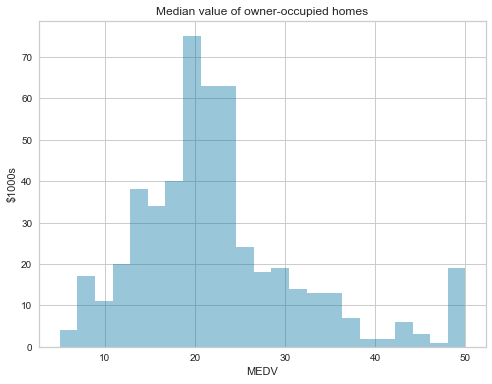

In [5]:
fig, ax = plt.subplots(figsize=(8,6)); 
sns.distplot(df_boston.MEDV, kde=False, ax=ax);
ax.set_ylabel("$1000s");
ax.set_title("Median value of owner-occupied homes");

### Median value increases strongly if the lower-status percentage is low, lower-value properties are typically owned in areas with a higher percentage of lower-status people

The relationship is roughly linear but is best exploited by a non-linear estimator.

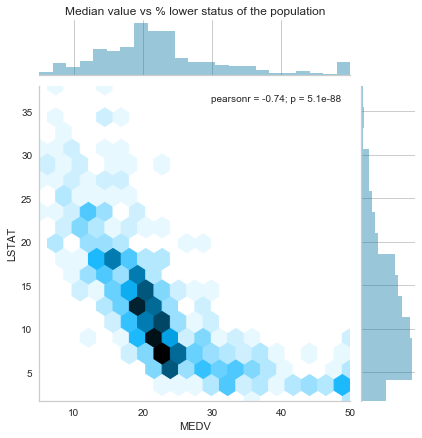

In [6]:
jg = sns.jointplot(df_boston.MEDV, df_boston.LSTAT, kind='hex')
jg.ax_marg_x.set_title("Median value vs % lower status of the population");

### Median value increases as the average number of rooms per property increases 

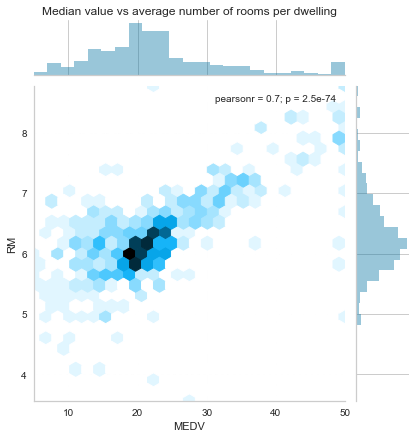

In [7]:
jg = sns.jointplot(df_boston.MEDV, df_boston.RM, kind='hex')
jg.ax_marg_x.set_title("Median value vs average number of rooms per dwelling");

# Build small RandomForestRegressor

In [8]:
# this is a deliberately limited regressor to keep things simple
est = sklearn.ensemble.RandomForestRegressor(n_estimators=30,
                                             max_depth=3,
                                             random_state=0)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(boston.data, 
                                                                            boston.target, 
                                                                            train_size=0.80, 
                                                                            random_state=0)
print("Sizes for train {}, test {}".format(X_train.shape, X_test.shape))
est.fit(X_train, y_train)


Sizes for train (404, 13), test (102, 13)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [9]:
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test, est.predict(X_test))

print('Random Forest MSError', mse_test)
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))

Random Forest MSError 22.0188463459
MSError when predicting the mean 81.5823174391


# Use LIME to explain an example

* http://lime-ml.readthedocs.io/en/latest/lime.html
* http://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer.explain_instance
* http://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_base.LimeBase.explain_instance_with_data
* `explain_instance` https://github.com/marcotcr/lime/blob/master/lime/lime_base.py#L166

In [10]:
example_to_explain_idx = 0 
example_to_explain = X_test[example_to_explain_idx]
feature_names = boston.feature_names

print("Explaining the {}th row".format(example_to_explain_idx))

Explaining the 0th row


In [11]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names=feature_names, 
                                                   class_names=['price'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

* Uses perturbed data `neighborhood_data` and `neighborhood_labels`
* `Intercept` is the generated linear model's intercept
* `Prediction_local` is the predicted output from the linear model
* `Right` is the predicted value from the explained regressor (not LIME's linear model)

In [12]:
exp = explainer.explain_instance(example_to_explain, est.predict, num_features=10)

Intercept 22.8102269385
Prediction_local [ 23.58383189]
Right: 24.1127588815


On the 0th test example LIME shows LSTAT and RM as being the most important features. On multiple runs I see different answers but LSTAT and RM are consistently the most important.

An example of a screenshot of the following output can be found in this bug report: https://github.com/marcotcr/lime/issues/88

In [13]:
# NOTE that the following HTML table doesn't render in GitHub so online this
# will be blank - locally it looks very pretty!
exp.show_in_notebook(show_table=True)

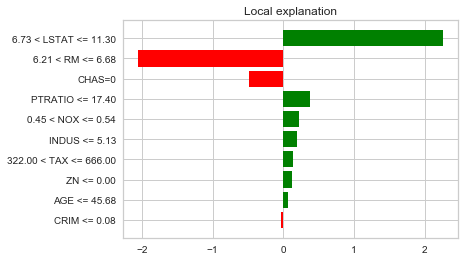

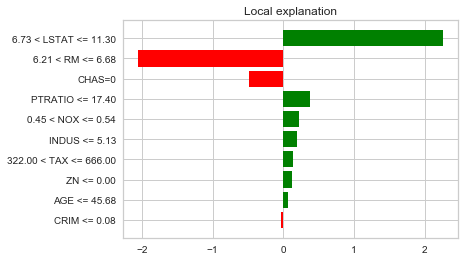

In [14]:
exp.as_pyplot_figure()

In [15]:
exp.as_list()

[('6.73 < LSTAT <= 11.30', 2.2530431526365113),
 ('6.21 < RM <= 6.68', -2.0492641254975013),
 ('CHAS=0', -0.48919986051228342),
 ('PTRATIO <= 17.40', 0.37551390063052709),
 ('0.45 < NOX <= 0.54', 0.21968649659675252),
 ('INDUS <= 5.13', 0.18594327503428709),
 ('322.00 < TAX <= 666.00', 0.13554166177726365),
 ('ZN <= 0.00', 0.11900246233032843),
 ('AGE <= 45.68', 0.058712986800546152),
 ('CRIM <= 0.08', -0.03537499541880252)]

# Use ELI5 to explain an example

**TODO** explain the BIAS, I'm not convinced by my mean-of-training argument - see http://blog.datadive.net/interpreting-random-forests/

On the 0th test example the explanation shows LSTAT and RM as the most important features.

In [16]:
print("BIAS is the mean of the training data (i.e. a guess prior to using any features):", y_train.mean())

BIAS is the mean of the training data (i.e. a guess prior to using any features): 22.6118811881


In [17]:
show_prediction(est, example_to_explain, feature_names=feature_names, show_feature_values=True)

# Visualising the model's feature importances 

## Feature importance as a box plot

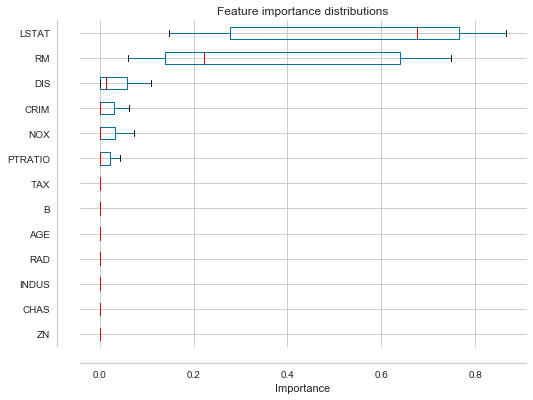

In [18]:
df = pd.DataFrame()
for est_idx, est_tree in enumerate(est.estimators_):
    df["tree_{}".format(est_idx)] = est_tree.feature_importances_
df = df.set_index(boston.feature_names)
df = df.T # transpose the dataframe

sorted_index = df.mean(axis=0).sort_values().index

fig, ax = plt.subplots(figsize=(8,6)); 
df[sorted_index].plot(kind="box", vert=False, ax=ax, title="Feature importance distributions");
ax.set_xlabel("Importance")

# remove right/top border to make things slightly neater
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# visual tidy-up to make left axis small values slightly easier to read
# offset left and bottom axis
ax.spines['bottom'].set_position(('axes', -0.05))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('axes', -0.05))

### A strip-plot shows the outliers more clearly than the box-plot itself

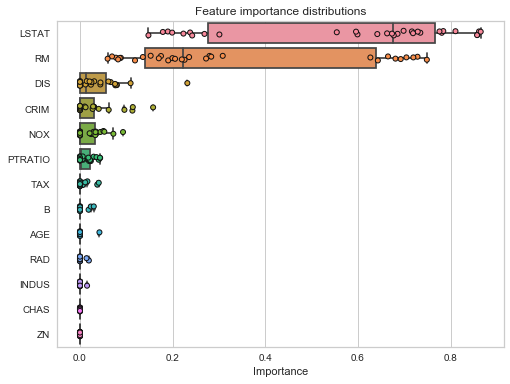

In [19]:
fig, ax = plt.subplots(figsize=(8,6)); 
sns.stripplot(data=df[sorted_index[::-1]], jitter=True, orient="h", ax=ax, edgecolor="k", linewidth=1);
sns.boxplot(data=df[sorted_index[::-1]], orient="h", ax=ax);
ax.set_title("Feature importance distributions");
ax.set_xlabel("Importance")

## Examine the weights of a single tree from the ensemble

In [20]:
est_tree0 = est.estimators_[0]

In [21]:
show_weights(est_tree0, feature_names=feature_names)

Weight,Feature
0.7166,LSTAT
0.2356,RM
0.0242,NOX
0.0237,DIS


# Iterate over the decision path in each estimator

**TODO** iterate over the steps in decision making, print the decisions that are made

* https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
* http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [22]:
example = example_to_explain.reshape((1,-1))
print(est_tree0.predict(example))

# we have 15 nodes, this set of decisions has 15 steps
# "Return a node indicator matrix where non zero elements indicates that the samples goes through the nodes."
decisions = np.array(est_tree0.decision_path(example).todense())[0,:]
decisions

[ 25.67195122]


array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
clf = est_tree0
X=pd.DataFrame(X_test)
list(zip(X.columns[clf.tree_.feature], clf.tree_.threshold, clf.tree_.children_left, clf.tree_.children_right))

[(12, 8.130000114440918, 1, 8),
 (5, 6.9019999504089355, 2, 5),
 (7, 1.4849499464035034, 3, 4),
 (11, -2.0, -1, -1),
 (11, -2.0, -1, -1),
 (5, 7.4449996948242188, 6, 7),
 (11, -2.0, -1, -1),
 (11, -2.0, -1, -1),
 (12, 15.100000381469727, 9, 12),
 (12, 9.7250003814697266, 10, 11),
 (11, -2.0, -1, -1),
 (11, -2.0, -1, -1),
 (4, 0.65699994564056396, 13, 14),
 (11, -2.0, -1, -1),
 (11, -2.0, -1, -1)]

### Show individual predictions from each tree in the estimator

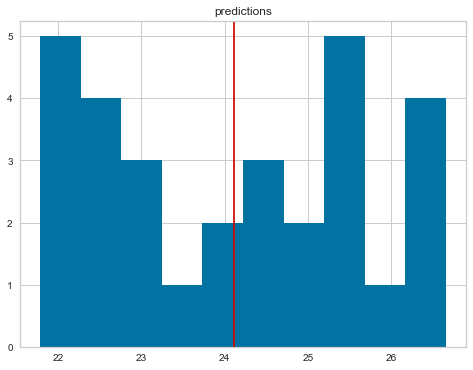

In [24]:
ensemble_prediction = est.predict(example)

predictions = []
for tree in est.estimators_:
    predictions.append(tree.predict(example))
    
df_predictions = pd.DataFrame(predictions, columns=['predictions'])

fig, ax = plt.subplots(figsize=(8,6)); 
df_predictions.hist(ax=ax)

ax.axvline(x=ensemble_prediction, c="r");

## Use ELI5's importance visualiser

**TODO** Note that the +/- value assumes a Gaussian and the boxplot above shows that this isn't true (also discussed here https://mail.python.org/pipermail/scikit-learn/2017-June/001615.html ), consider filing a bug against this

In [25]:
show_weights(est, feature_names=feature_names)

Weight,Feature
0.5757 ± 0.4907,LSTAT
0.3282 ± 0.4926,RM
0.0331 ± 0.0978,DIS
0.0241 ± 0.0830,CRIM
0.0184 ± 0.0494,NOX
0.0112 ± 0.0293,PTRATIO
0.0039 ± 0.0201,TAX
0.0024 ± 0.0146,B
0.0014 ± 0.0151,AGE
0.0011 ± 0.0084,RAD


# Visualise test-set errors

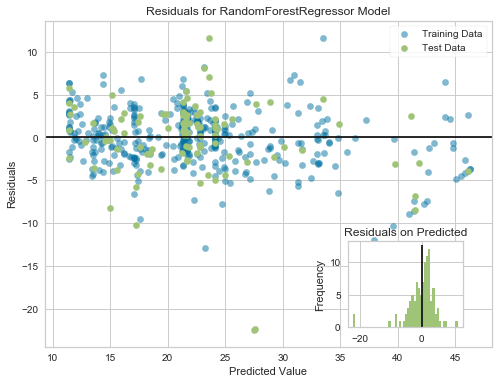

In [26]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

fig, ax = plt.subplots(figsize=(8,6)); 
visualizer = ResidualsPlot(est, ax=ax)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data


# add histogram of residual errors
# https://github.com/DistrictDataLabs/yellowbrick/issues/264
left, bottom, width, height = [0.65, 0.17, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

# we could plot the training residuals behind the testing residuals
# (but here we have 80% train, 20% test, so the y-axis is offset and this looks less useful)
#training_residuals = pd.Series(est.predict(X_train) - y_train)
#training_residuals.plot(kind="hist", bins=50, title="", ax=ax2, color='b', alpha=1);

testing_residuals = pd.Series(est.predict(X_test) - y_test)
testing_residuals.plot(kind="hist", bins=50, title="Residuals on Predicted", ax=ax2, color='g', alpha=1);
ax2.vlines(0, ymin=0, ymax=ax2.get_ylim()[1] ) # add x==0 line

g = visualizer.poof()             # Draw/show/poof the data

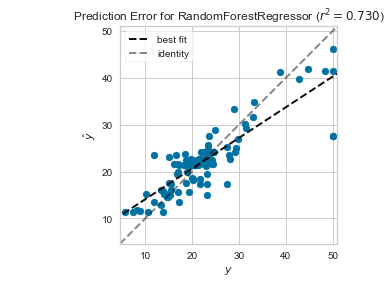

In [27]:
visualizer = PredictionError(est)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# To Add

* Read http://blog.datadive.net/interpreting-random-forests/ and use to augment the ELI5 description
* Add to LIME regression notes https://marcotcr.github.io/lime/tutorials/Using%2Blime%2Bfor%2Bregression.html and https://github.com/marcotcr/lime notes on applying feature probabilities to the class, read their notes https://github.com/marcotcr/lime/issues/3
* Iterate over each tree's prediction path
* Try https://github.com/andosa/treeinterpreter (older, apparently does support regression) and see if http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/ has value to ELI5